In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import itertools

In [2]:
np.set_printoptions(threshold=np.inf)

In [3]:
df = pd.read_excel('./data/Online Retail.xlsx')

# Questions to answer

* What are the best months for sales, and what products are selling best during those months?

* What is the customer breakdown? What's the distribution of high-value/mid-value/low-value customers?

* What is the average order per customer?

* What is the month-to-month churn rate

# Initial inspection of dataset

I want to check out what's going on in the dataset, so first thing I'll do is look at what values are missing and what needs to clean up

In [4]:
df.isnull().sum()

InvoiceNo         0
StockCode         0
Description    1454
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID        0
Country           0
dtype: int64

We have some NaN values in the Description column, but everything else is looking okay. So let's investigate this column a little more and see if there's anything useful in the NaNs, the dataset doesn't say anything about what NaNs represent.

In [5]:
nan_desc = df[df['Description'].isna()]

In [6]:
nan_desc['UnitPrice']

622       0.0
1970      0.0
1971      0.0
1972      0.0
1987      0.0
         ... 
535322    0.0
535326    0.0
535332    0.0
536981    0.0
538554    0.0
Name: UnitPrice, Length: 1454, dtype: float64

In [7]:
# Checking to see if there are any canceled orders with descriptions that are nan values, 
# because that would still be valuable information for us to have.
nan_desc['InvoiceNo'].astype('str').str.startswith('C').sum()

0

There are **1454 transactions with no description**, but the `UnitPrice` on each of these entries is 0, so for our analysis, we're going to remove them from our sales data. I would also ask the client if an empty description is significant to them. It could be an abandoned cart / deprecated method of indicating a return.

In [8]:
# Setting the index as a datetime object for easy resampling
df.set_index('InvoiceDate', inplace=True)

In [9]:
# Dropping the NaN values as mentioned above
df.dropna(inplace=True)

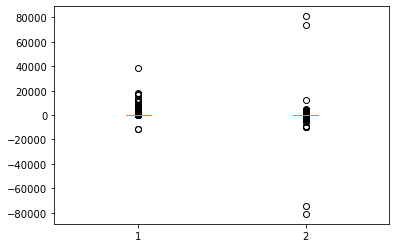

In [10]:
# Visualizing the distribution of our data.
plt.boxplot(df[['UnitPrice', 'Quantity']]);

In [11]:
df[['UnitPrice', 'Quantity']].describe()

,UnitPrice,Quantity
count,540455.000000,540455.000000
mean,4.623519,9.603129
std,96.889628,218.007598
min,-11062.060000,-80995.000000
25%,1.250000,1.000000
50%,2.080000,3.000000
75%,4.130000,10.000000
max,38970.000000,80995.000000


75% of our transactions have a unit price under \\$4.13. I'll need to investigate the outliers further to see what transactions have such a high `UnitPrice`.

Also, it looks like our `Quantity` column might show as negative for canceled transactions - we'll need to clean that up. 

In [12]:
df[df['UnitPrice'] > 500]['Description'].unique()

array(['DOTCOM POSTAGE', 'Manual', 'AMAZON FEE', 'Bank Charges',
       'Discount', 'POSTAGE', 'PICNIC BASKET WICKER 60 PIECES', 'SAMPLES',
       'Adjust bad debt', 'CRUK Commission'], dtype=object)

**Most of the items with a `UnitPrice` above 500 are not related to specific items**. These seem to be shipping/fees/commission and manual entries of data. We'll remove these descriptions when analyzing our sales data, since they don't tell us anything about the products that are selling well.

# Feature Engineering

There are some features that would be helpful to calculate. Some of the things that are missing are:
* `TotalSale`: `UnitPrice` * `Quantity`
* `CanceledOrder`: boolean that shows whether `InvoiceNo` starts with 'C'

In [13]:
order_canceled = ~df['InvoiceNo'].str.startswith('C').isna()

In [14]:
unit_x_quantity = lambda x: x['UnitPrice'] * x['Quantity']

In [15]:
# Currently no way of knowing total sale per transaction
df['TotalSale'] = df.apply(unit_x_quantity, axis=1)

In [16]:
# Create a column that determines whether an order was canceled or not
df['CanceledOrder'] = order_canceled

# Cleaning the data

Our data has a lot of descriptions that are not relevant to the product sales question - things like shipping, damaged items, lost items, etc. The non-product related descriptions all seem to be lowercase, while sales-related descriptions seem to be uppercase. So, we will separate these two different categories into separate dataframes. One for product-related descriptions, and one for returns/shipping/damaged items.


In [17]:
# Even after cleaning the data, there are still some outlier descriptions that require manual filtering
sales_desc = ['FRENCH BLUE METAL DOOR SIGN No', 
                "Dr. Jam's Arouzer Stress Ball",
                '3 TRADITIONAl BISCUIT CUTTERS  SET',
                'NUMBER TILE VINTAGE FONT No ',
                '*USB Office Mirror Ball',
                '*Boombox Ipod Classic',
                'NUMBER TILE COTTAGE GARDEN No',
                'FLOWERS HANDBAG blue and orange',
                "Dad's Cab Electronic Meter"]

In [18]:
# Similarly to above, there are some non_sales descriptions that were capitalized
non_sales_desc = ['AMAZON FEE',
                 'DOTCOM POSTAGE',
                 'POSTAGE',
                 'SAMPLES']

In [19]:
# Create filters that will capture all of the sales data. Note that some of the sales 
is_uppercase = df['Description'].str.upper() == df['Description']
contains_num_and_letter = df['Description'].str.contains('\d\w')
is_in_sales_desc = df['Description'].isin(sales_desc)
not_in_non_sales_desc = ~df['Description'].isin(non_sales_desc)
no_question_mark = ~df['Description'].astype('str').str.contains('\?')

# This filter eliminates any non-sale related transactions
non_zero_unit = df['UnitPrice'] != 0

In [20]:
description_sales = ((is_uppercase) | (contains_num_and_letter) | (is_in_sales_desc)) & (not_in_non_sales_desc)

In [21]:
df_sales = df[(description_sales) & (no_question_mark)]

In [22]:
# Setting df_other to the inverse of df_sales 
df_other = df[(~description_sales) & (df['Description'].notnull())]

# EDA Part II:

Now that I've cleaned my data up a bit, we can look at sales again.

In [23]:
# One more pass to see if there's any resitual non-sales data that didn't get caught by our filters
final_check = df_sales[(~df_sales['CanceledOrder']) & (df_sales['Quantity'] < 0)]
remaining_non_sales = final_check['Description'].tolist()

In [24]:
# Removing those final descriptions from our sales dataset
df_sales = df_sales[~df_sales['Description'].isin(remaining_non_sales)]

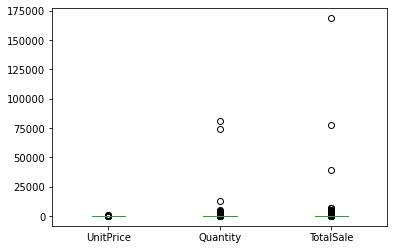

In [25]:
# Distribution of UnitPrice and Quantity. Removed canceled orders for readability.
df_sales[~df_sales['CanceledOrder']][['UnitPrice', 'Quantity', 'TotalSale']].plot(kind='box');

The outliers are throwing off the readability of our boxplot, and all the orders with quantities above 5000 are orders that were canceled within minutes (Though invoice C536757 "ROTATING SILVER ANGELS..." doesn't have a corresponding sale). I'm going to remove transactions with an absolute value of quantity above 5000

In [26]:
# Inspecting transactions with an absolute value of quantity greater than 5000
df_sales[abs(df_sales['Quantity']) > 5000][['InvoiceNo', 'Description', 'Quantity', 'UnitPrice', 'TotalSale']]

,InvoiceNo,Description,Quantity,UnitPrice,TotalSale
InvoiceDate,,,,,
2010-12-02 14:23:00,C536757,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,0.03,-280.8
2011-01-18 10:01:00,541431,MEDIUM CERAMIC TOP STORAGE JAR,74215,1.04,77183.6
2011-01-18 10:17:00,C541433,MEDIUM CERAMIC TOP STORAGE JAR,-74215,1.04,-77183.6
2011-11-25 15:57:00,578841,ASSTD DESIGN 3D PAPER STICKERS,12540,0.00,0.0
2011-12-09 09:15:00,581483,"PAPER CRAFT , LITTLE BIRDIE",80995,2.08,168469.6
2011-12-09 09:27:00,C581484,"PAPER CRAFT , LITTLE BIRDIE",-80995,2.08,-168469.6


In [27]:
# Removing transactions with an absolute value of quantity greater than 5000
df_sales = df_sales[abs(df_sales['Quantity']) < 5000]

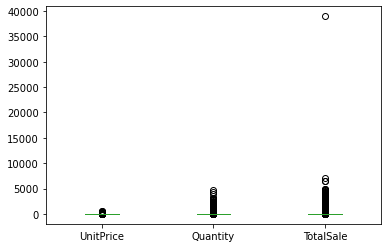

In [28]:
df_sales[~df_sales['CanceledOrder']][['UnitPrice', 'Quantity', 'TotalSale']].plot(kind='box');

In [29]:
# We're clean! Saving dataframe as a csv.
# df_sales.to_csv('./data/Online Retail Sales.csv')

In [30]:
df_sales[['UnitPrice', 'Quantity']].describe()

,UnitPrice,Quantity
count,536974.000000,536974.000000
mean,3.293063,9.914657
std,4.562556,38.781697
min,0.000000,-3114.000000
25%,1.250000,1.000000
50%,2.080000,3.000000
75%,4.130000,10.000000
max,649.500000,4800.000000


Our summary statistics look similar to what we found in the original EDA. **75% of our data still has a unit price under \$4.13.** But now our standard deviation is now much smaller (~4.6 compared to ~96.8)

# Creating a Date Scaffold
Let's prep the data to do some customer churn calculations by building a date scaffold that will show whether a customer was active across the full range of dates. Currently, customers who churn and don't come back won't be picked up by the dataset because their start / end dates aren't tracked.

In [31]:
scaffold = df_sales.groupby('CustomerID').resample('M').mean().index

In [32]:
# Getting all unique customer IDs
cust_ids = df['CustomerID'].value_counts().index

In [33]:
# Getting all months in the full date range, sorting them for sanity.
date_list = sorted(list({date[1] for date in scaffold}))

In [34]:
# Creating a date scaffold to track churn rate
date_scaffold = date_list * len(cust_ids)

In [35]:
# Need to match the number of dates with customer ids
cust_ids = [[cust_id] * len(date_list) for cust_id in cust_ids]

In [36]:
# And let's join all the nested lists I just made
cust_ids = list(itertools.chain.from_iterable(cust_ids))

In [37]:
# Zipping these into a tuple to make a multi index
tuples = list(zip(cust_ids, date_scaffold))

In [38]:
# Creating a multi index - from pandas documentation
multiindex = pd.MultiIndex.from_tuples(tuples, names=['CustomerID', 'InvoiceDate'])

# Generating customer segments using bins

I want to be able to visualize different customer segments, so I'll create a new dataframe that splits customers into segments.

In [39]:
customer_summary = pd.DataFrame(index=multiindex)

In [40]:
# Let's grab the total sales per customer, we'll use this to generate customer segments
customer_summary['SumTotalSale'] = df_sales.groupby('CustomerID').resample('M').sum()['TotalSale']

In [41]:
# Renaming this so it doesn't get confusing when we join it with our original dataset
customer_summary.rename(columns={'TotalSale': 'SumTotalSale'}, inplace=True)

In [42]:
# Let's grab the average unit price per customer, this will be helpful for understanding buying
# habits of our different customer segments
customer_summary['AvgUnitPrice'] = df_sales.groupby('CustomerID').resample('M').mean()['UnitPrice']

In [43]:
# Let's grab the average Quantity per customer. Similarly, this can help understand buying habits
# of different customer segments
customer_summary['AvgQuantity'] = df_sales.groupby('CustomerID').resample('M').mean()['Quantity']

In [44]:
customer_summary['TotalOrders'] = df_sales.groupby('CustomerID').resample('M').nunique()['InvoiceNo']

In [45]:
# Need to fill the NaN values with 0, they're cause when a user made no purchases in a given month
customer_summary.fillna(0, inplace=True)

In [46]:
# Creating the customer segments, breaking them into 4 categories
customer_summary['Segment'] = customer_summary['SumTotalSale'].apply(lambda x:\
                                                '< £1k' if 0 < x < 1000 else\
                                               ('£1k - £5k' if 1000 < x < 5000 else\
                                               ('£5k - £10k' if 5000 < x < 10000 else\
                                               ('> £10k' if 10000 < x else 'No Sales'))))


# Calculating Customer Churn
With this dataset, churn rate was very hard to calculate using Tableau alone. Let's create some columns that will help with our calculations when transferring the data over to Tableau.

In [47]:
# Detecting whether a customer has churned based on the previous month
customer_summary['Churned'] = customer_summary['SumTotalSale'].apply(lambda x: 0 if x <= 0 else 1).diff()
customer_summary['Churned'] = customer_summary['Churned'].apply(lambda x: 1 if x == -1 else 0)

In [49]:
# Some of the calculations resulted in NaN because there was no data for the customer in a given month. 
# I'll replace those with zeroes
customer_summary.fillna(0, inplace=True)

In [50]:
# Adding the invoice date column back in, currently it's inaccessible in the multiindex
customer_summary['InvoiceDateCol'] = customer_summary.droplevel(0).index

In [51]:
# Shifting the customer segments so I can count up which segments churned most frequently
customer_summary['Segment_shifted'] = customer_summary['Segment'].shift()

In [52]:
# None of the first entries should have any Churn since there's no prior data
customer_summary.loc[customer_summary['InvoiceDateCol'] == '2010-12-31', 'Churned'] = 0

In [53]:
# Need to get the total customers from the previous month
total_customers_per_month = customer_summary[customer_summary['SumTotalSale'] > 0].groupby('InvoiceDate').count()['Churned'].shift()

In [54]:
# Couldn't create churn rate in Tableau effectively, so I'm creating it here by taking the
# sum of the Churned column (number churned) divided by the total number of customers in the previous
# month
churn_rate = customer_summary.groupby('InvoiceDate').sum()['Churned'] / total_customers_per_month

In [1]:
churn_rate

NameError: name 'churn_rate' is not defined

In [56]:
# Need to 
churn_rate.name = 'ChurnRate'

In [57]:
# Now I need to join this churn rate to the original dataframe
customer_summary = customer_summary.join(churn_rate, rsuffix='ChurnRate')

In [59]:
# Let's turn this into a csv. We can join it with the original dataset in Tableau.
customer_summary.to_csv('./data/Customer Segments_monthly.csv')